In [1]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

In [2]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [3]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [4]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "middle_fmr.zip" -d {TRAIN_PATH}

In [5]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [6]:
int(1088 * 0.1)

108

In [7]:
photo_1 = '/content/cars/Ferrari/car_Ferrari__0.png'
photo_1 = '/content/cars_test/Ferrari/car_Ferrari__0.png'

In [8]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [9]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [10]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [11]:
len(train_generator[0]) == 24

False

In [12]:
train_generator[0]
# (список пар изображений-меток)

(array([[[[0.7294118 , 0.7725491 , 0.8117648 ],
          [0.73333335, 0.7725491 , 0.8117648 ],
          [0.73333335, 0.7725491 , 0.81568635],
          ...,
          [0.69803923, 0.7137255 , 0.7568628 ],
          [0.69803923, 0.7137255 , 0.7568628 ],
          [0.69803923, 0.7137255 , 0.7568628 ]],
 
         [[0.6862745 , 0.7372549 , 0.7725491 ],
          [0.6862745 , 0.7372549 , 0.7725491 ],
          [0.6901961 , 0.7411765 , 0.77647066],
          ...,
          [0.69803923, 0.7137255 , 0.7568628 ],
          [0.69803923, 0.7137255 , 0.7568628 ],
          [0.69803923, 0.7137255 , 0.7568628 ]],
 
         [[0.63529414, 0.69803923, 0.74509805],
          [0.6392157 , 0.7019608 , 0.7490196 ],
          [0.6392157 , 0.7019608 , 0.74509805],
          ...,
          [0.69803923, 0.7137255 , 0.7568628 ],
          [0.69803923, 0.7137255 , 0.7568628 ],
          [0.69803923, 0.7137255 , 0.7568628 ]],
 
         ...,
 
         [[0.5254902 , 0.4784314 , 0.4431373 ],
          [0.60784

In [13]:
train_generator[0][0]
# (изображение, метка)

array([[[[0.8235295 , 0.882353  , 0.9215687 ],
         [0.8235295 , 0.882353  , 0.9215687 ],
         [0.8235295 , 0.882353  , 0.9215687 ],
         ...,
         [0.7843138 , 0.8000001 , 0.85098046],
         [0.7843138 , 0.8000001 , 0.85098046],
         [0.7843138 , 0.8000001 , 0.85098046]],

        [[0.8235295 , 0.882353  , 0.9215687 ],
         [0.8235295 , 0.882353  , 0.9215687 ],
         [0.8235295 , 0.882353  , 0.9215687 ],
         ...,
         [0.7843138 , 0.8000001 , 0.85098046],
         [0.7843138 , 0.8000001 , 0.85098046],
         [0.7843138 , 0.8000001 , 0.85098046]],

        [[0.8235295 , 0.882353  , 0.9215687 ],
         [0.8235295 , 0.882353  , 0.9215687 ],
         [0.8235295 , 0.882353  , 0.9215687 ],
         ...,
         [0.7843138 , 0.8000001 , 0.85098046],
         [0.7843138 , 0.8000001 , 0.85098046],
         [0.7843138 , 0.8000001 , 0.85098046]],

        ...,

        [[0.20392159, 0.21568629, 0.1254902 ],
         [0.18823531, 0.19607845, 0.10980393]

In [14]:
train_generator[0][0][0]
# изображение

array([[[0.6313726 , 0.6784314 , 0.7058824 ],
        [0.60784316, 0.654902  , 0.6862745 ],
        [0.61960787, 0.65882355, 0.6901961 ],
        ...,
        [0.5254902 , 0.56078434, 0.6039216 ],
        [0.5176471 , 0.5568628 , 0.6039216 ],
        [0.5176471 , 0.5568628 , 0.6       ]],

       [[0.68235296, 0.7137255 , 0.7372549 ],
        [0.654902  , 0.6862745 , 0.7137255 ],
        [0.6509804 , 0.68235296, 0.70980394],
        ...,
        [0.24705884, 0.32156864, 0.3647059 ],
        [0.19607845, 0.27450982, 0.31764707],
        [0.14117648, 0.22352943, 0.27058825]],

       [[0.7725491 , 0.77647066, 0.7843138 ],
        [0.77647066, 0.7843138 , 0.79215693],
        [0.75294125, 0.7607844 , 0.7725491 ],
        ...,
        [0.0509804 , 0.14117648, 0.18039216],
        [0.0509804 , 0.14117648, 0.18039216],
        [0.0509804 , 0.14117648, 0.18039216]],

       ...,

       [[0.4784314 , 0.43921572, 0.40784317],
        [0.52156866, 0.48627454, 0.45098042],
        [0.5686275 , 0

In [15]:
train_generator[0][0][1]
# метка

array([[[0.6862745 , 0.69803923, 0.70980394],
        [0.6901961 , 0.7019608 , 0.70980394],
        [0.69411767, 0.7058824 , 0.7137255 ],
        ...,
        [0.7411765 , 0.74509805, 0.7411765 ],
        [0.7411765 , 0.74509805, 0.7411765 ],
        [0.7411765 , 0.74509805, 0.7411765 ]],

       [[0.6862745 , 0.69803923, 0.70980394],
        [0.6901961 , 0.7019608 , 0.70980394],
        [0.69411767, 0.7058824 , 0.7137255 ],
        ...,
        [0.7411765 , 0.74509805, 0.7411765 ],
        [0.7411765 , 0.74509805, 0.7411765 ],
        [0.7411765 , 0.74509805, 0.7411765 ]],

       [[0.6862745 , 0.69803923, 0.70980394],
        [0.6901961 , 0.7019608 , 0.70980394],
        [0.69411767, 0.7058824 , 0.7137255 ],
        ...,
        [0.7411765 , 0.74509805, 0.7411765 ],
        [0.7411765 , 0.74509805, 0.7411765 ],
        [0.7411765 , 0.74509805, 0.7411765 ]],

       ...,

       [[0.10980393, 0.10980393, 0.10980393],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.1254902 , 0

In [16]:
class Some:
  def __init__(self, array):
    self.array = array
  def run(self):
    return '123'

  def __len__(self):
    return len(self.array)

In [17]:
sss = Some([1,2,3,4,5])

In [18]:
sss.run()

'123'

In [19]:
len(sss.array)

5

In [20]:
len(sss)

5

In [21]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 103
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 26
Формы данных      тестовой выборки: (341, 64, 128, 3), (341, 3), батчей: 1

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


In [22]:
len(train_generator)

103

In [23]:
len(train_generator[0])

2

In [24]:
x_train, y_train = train_generator[0]

In [25]:
len(x_train), len(y_train)

(24, 24)

In [26]:
y_train[0].shape

(3,)

In [27]:
x_train[0].shape

(64, 128, 3)

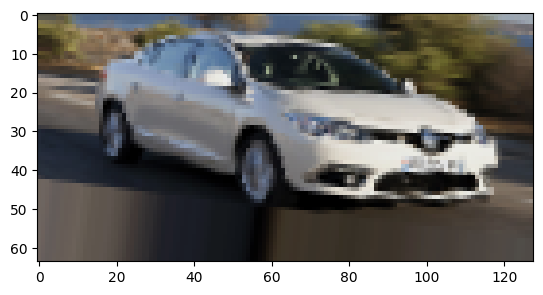

In [28]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [29]:
train_generator[1][0][2]

array([[[0.6039216 , 0.6431373 , 0.68235296],
        [0.6039216 , 0.6431373 , 0.68235296],
        [0.6039216 , 0.6431373 , 0.68235296],
        ...,
        [0.57254905, 0.6       , 0.63529414],
        [0.57254905, 0.6       , 0.63529414],
        [0.57254905, 0.6       , 0.63529414]],

       [[0.6039216 , 0.6431373 , 0.68235296],
        [0.6039216 , 0.6431373 , 0.68235296],
        [0.6039216 , 0.6431373 , 0.68235296],
        ...,
        [0.5686275 , 0.6       , 0.6313726 ],
        [0.5686275 , 0.6       , 0.6313726 ],
        [0.5686275 , 0.6       , 0.6313726 ]],

       [[0.6039216 , 0.6431373 , 0.68235296],
        [0.6039216 , 0.6431373 , 0.68235296],
        [0.6039216 , 0.6431373 , 0.68235296],
        ...,
        [0.5647059 , 0.59607846, 0.6313726 ],
        [0.5647059 , 0.59607846, 0.6313726 ],
        [0.5647059 , 0.59607846, 0.6313726 ]],

       ...,

       [[0.35686275, 0.32941177, 0.30980393],
        [0.3647059 , 0.3372549 , 0.31764707],
        [0.35686275, 0

In [31]:
x_train, y_train = train_generator[0]

In [32]:
batch = train_generator[0]

In [34]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

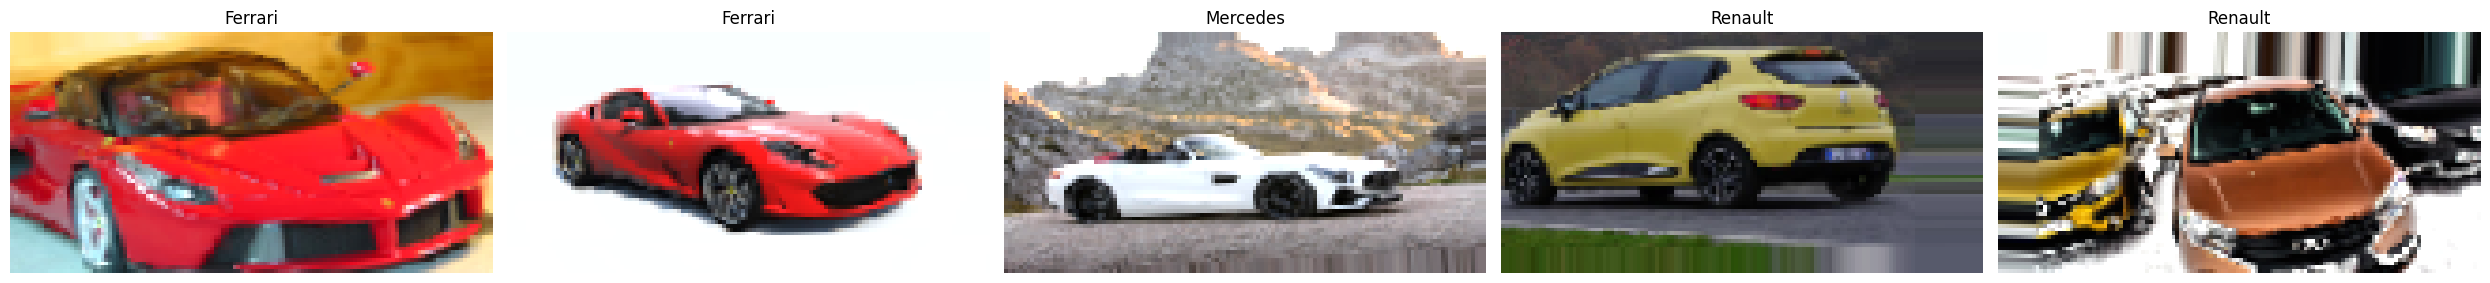

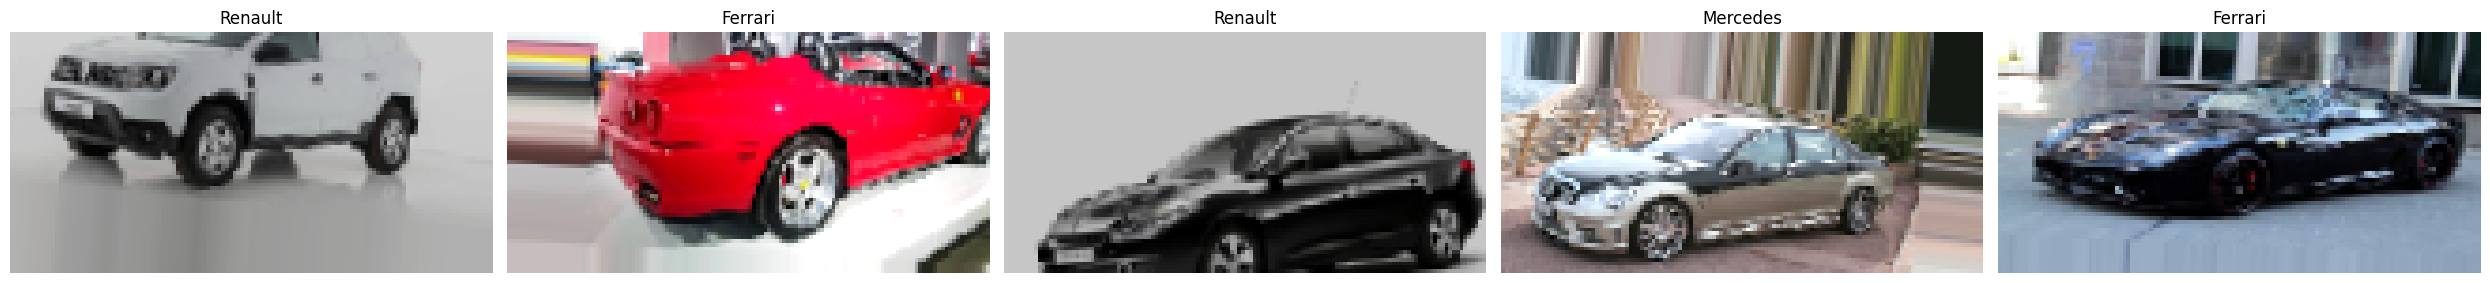

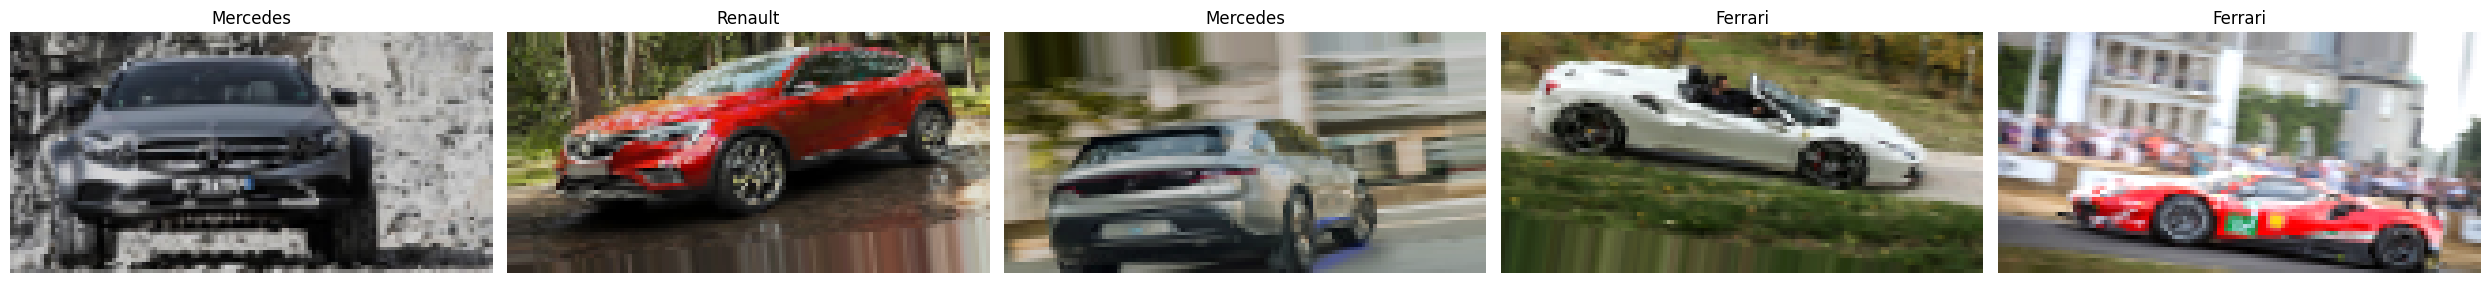

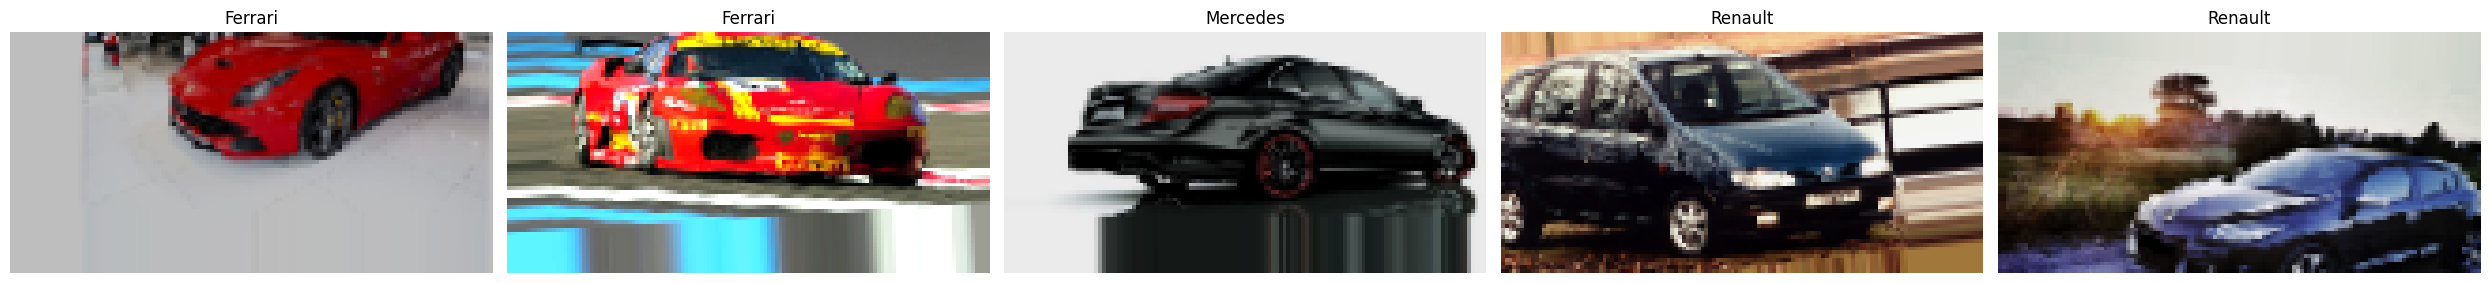

In [35]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

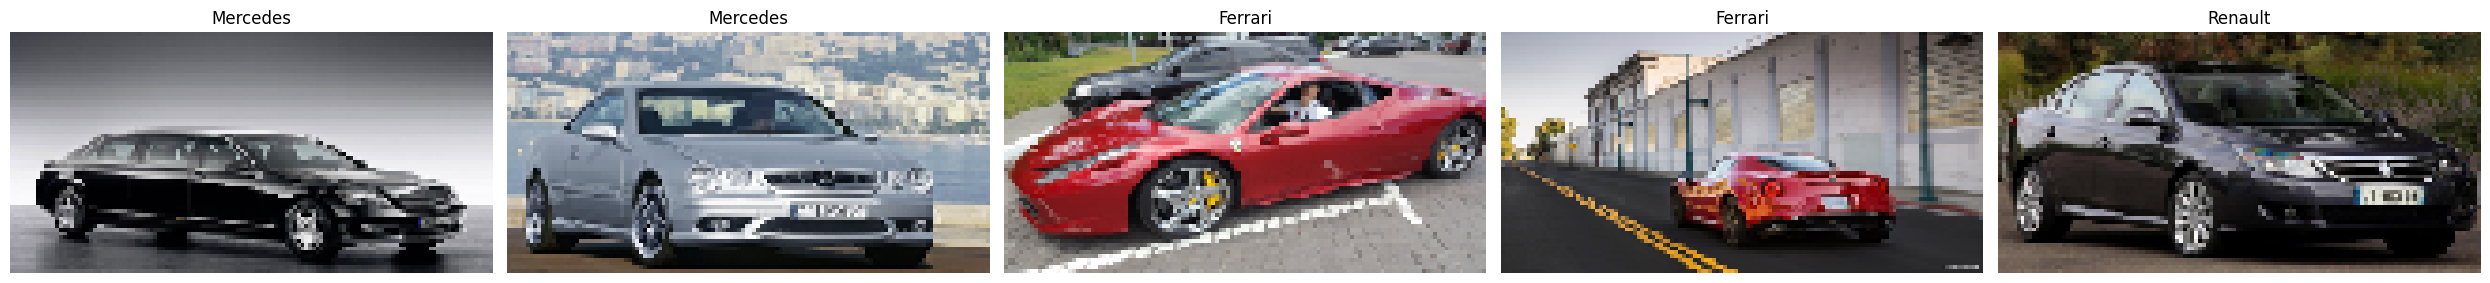

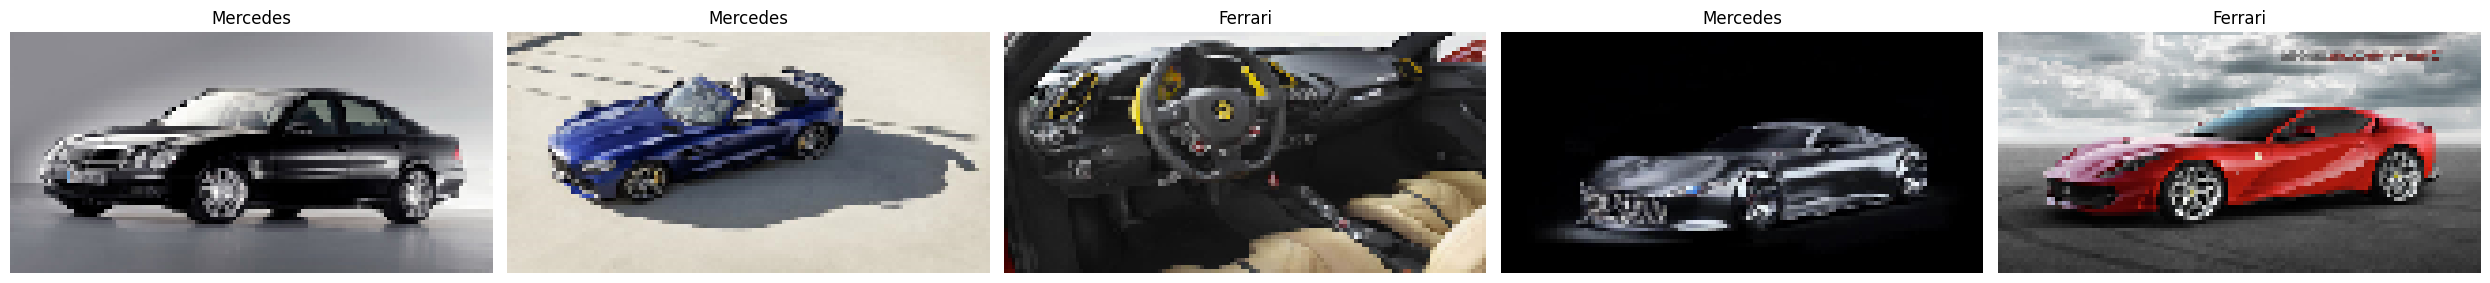

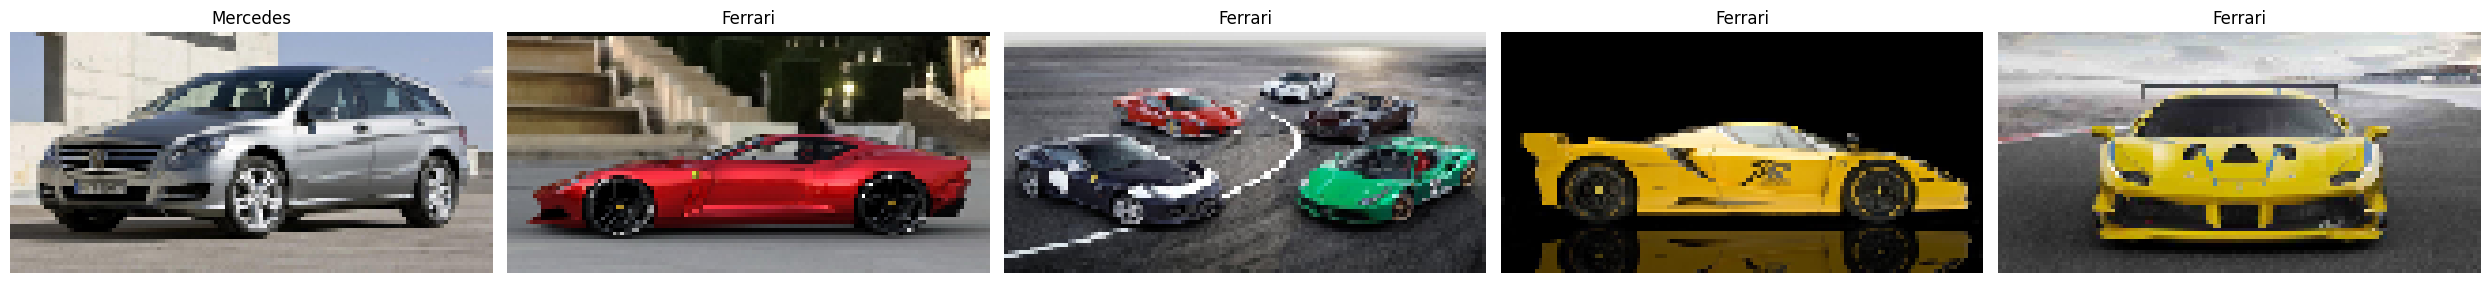

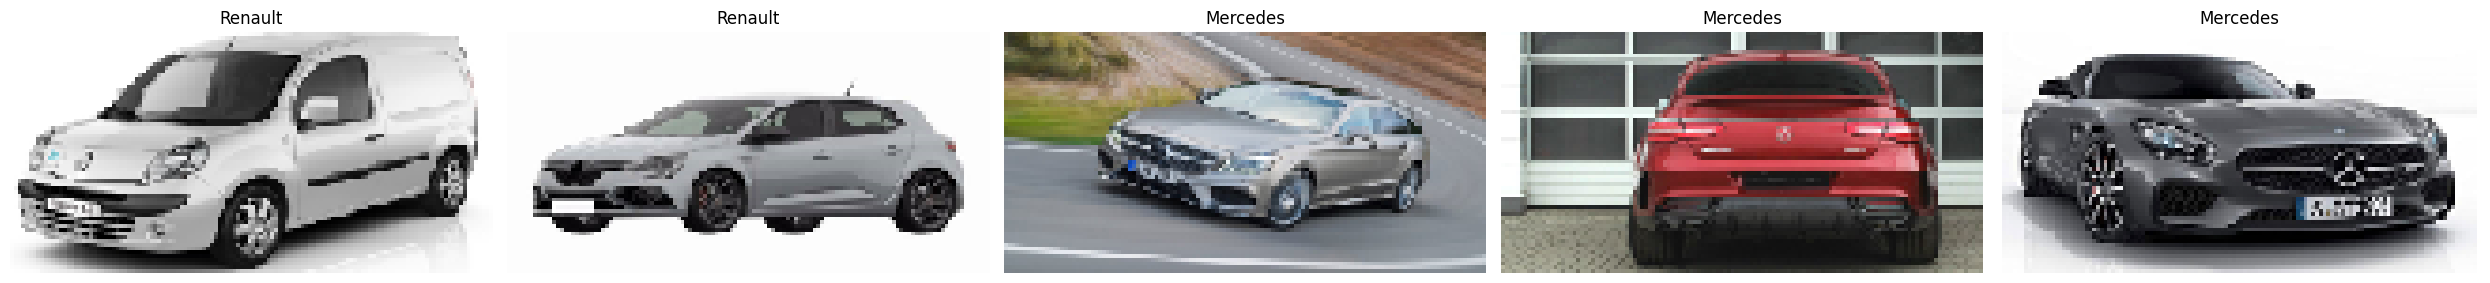

In [36]:
# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

In [37]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [38]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [39]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

In [ ]:
# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())

# Второй сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.2))

# Четвертый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Пятый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())

# Шестой сверточный слой
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Слой преобразования многомерных данных в одномерные
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(2048, activation='relu'))

# Промежуточный полносвязный слой
model_conv.add(Dense(4096, activation='relu'))

# Выходной полносвязный слой с количеством нейронов по количесту классов
model_conv.add(Dense(CLASS_COUNT, activation='softmax'))


# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 128, 256)   │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 128, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 42, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 42, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 42, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 14, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 14, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 14, 1024)    │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,865,539 (125.37 MB)

 Trainable params: 32,863,491 (125.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 1544s 15s/step - accuracy: 0.4400 - loss: 1.5684 - val_accuracy: 0.3387 - val_loss: 1.2353
Epoch 2/60
 18/103 ━━━━━━━━━━━━━━━━━━━━ 19:29 14s/step - accuracy: 0.5091 - loss: 0.9918